<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/03_pytorch_computer_vision_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. PyTorch Computer Vision Exercises

The following is a collection of exercises based on computer vision fundamentals in PyTorch.

They're a bunch of fun.

You're going to get to write plenty of code!

## Resources

1. These exercises are based on [notebook 03 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/03_pytorch_computer_vision/). 
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/_PibmqpEyhA). 
  * **Note:** Going through these exercises took me just over 3 hours of solid coding, so you should expect around the same.
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

# Check for GPU
!nvidia-smi

In [50]:
# Import torch
import torch

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# TODO: Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

2.9.1+cu130


## 1. What are 3 areas in industry where computer vision is currently being used?

1. Autonomous driving
2. Classification of different items (e.g. food detection in Calorie tracking apps)
3. Facial recognition

## 2. Search "what is overfitting in machine learning" and write down a sentence about what you find. 

When model is too well trained on the training set, such that it performs worse on test or actual data

## 3. Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each. 
> **Note:** there are lots of these, so don't worry too much about all of them, just pick 3 and start with those.

1. Use a larger training dataset
2. Early stopping -> stop when model performance on validation set starts to degrade
3. Regularization -> penalty term is added to the function the model is trying to optimize. This helps prevent the model from fitting too closely to the training data

## 4. Spend 20-minutes reading and clicking through the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

* Upload your own example image using the "upload" button on the website and see what happens in each layer of a CNN as your image passes through it.

## 5. Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [51]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

train_data = MNIST(root="data", train=True, transform=ToTensor(), target_transform=None, download=True)
test_data = MNIST(root="data", train=False, transform=ToTensor(), target_transform=None, download=True)

In [52]:
len(train_data), len(test_data)

(60000, 10000)

## 6. Visualize at least 5 different samples of the MNIST training dataset.

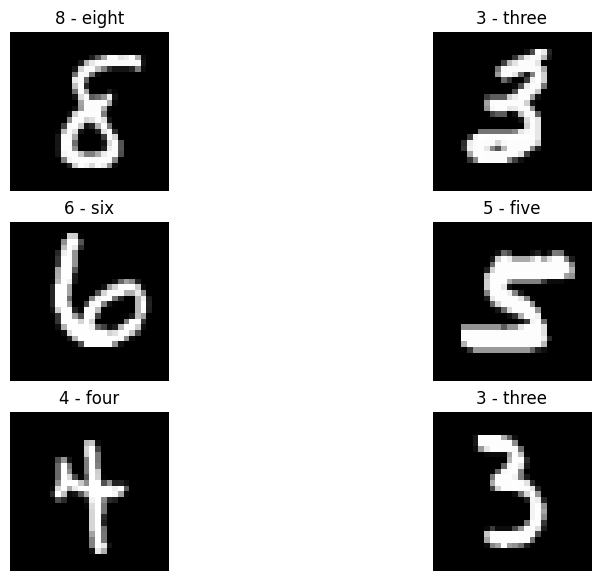

In [53]:
import random

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=6):
    test_samples.append(sample)
    test_labels.append(label)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
for i in range(len(test_samples)):
    plt.subplot(3, 2, i+1)
    plt.imshow(test_samples[i].squeeze(), cmap='gray')
    plt.title(test_data.classes[test_labels[i]])
    plt.grid(False)
    plt.axis(False)

## 7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [54]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_data, batch_size=32, shuffle=True, num_workers=2)
test_dataloader = DataLoader(dataset=test_data, batch_size=32, shuffle=True, num_workers=2)

In [55]:
img, label = train_data[0]

img.shape, label

(torch.Size([1, 28, 28]), 5)

## 8. Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [56]:
from torch import nn

class MNISTModel(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden_units: int):
        super().__init__()

        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
        )

    def forward(self, X: torch.Tensor):
        X = self.conv_1(X)
        X = self.conv_2(X)
        X = self.classifier(X)
        return X

In [57]:
model_0 = MNISTModel(input_shape=1, output_shape=len(test_data.classes), hidden_units=32)
model_1 = MNISTModel(input_shape=1, output_shape=len(test_data.classes), hidden_units=32).to(device)

## 9. Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.

In [58]:
from torchmetrics import Accuracy

In [59]:
loss_fn = nn.CrossEntropyLoss()
optimizer_0 = torch.optim.SGD(params=model_0.parameters(), lr=0.1)
optimizer_1 = torch.optim.SGD(params=model_1.parameters(), lr=0.1)
acc_fn = Accuracy(task='multiclass', num_classes=len(train_data.classes))

In [60]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               acc_fn: Accuracy,
               device: torch.device = device):
    '''Performs training with model trying to learn on data_loader'''
    train_loss, train_acc = 0, 0

    model.train()

    acc_fn = acc_fn.to(device)

    # Add a loop to loop through the training batch
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)

        # Loss
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulate training loss

        train_acc += acc_fn(y_pred.argmax(dim=1), y)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
    
    # Divide total training loss and accuracy by length of train dataloader
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.5f}")

In [61]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               acc_fn: Accuracy,
               device: torch.device = device):
    '''Performs testing with model going over data_loader'''
    test_loss, test_acc = 0, 0
    
    model.eval()

    acc_fn = acc_fn.to(device)

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            # Forward pass
            test_pred = model(X)

            # Loss
            test_loss += loss_fn(test_pred, y)

            # Accuracy
            test_acc += acc_fn(test_pred.argmax(dim=1), y)

        # Calculate avg. test loss per batch
        test_loss /= len(data_loader)

        # Calculate test accuracy avg. per batch
        test_acc /= len(data_loader)

        print(f"Test loss: {test_loss:.5f}, Test acc: {test_acc:.5f}")

In [62]:
from timeit import default_timer as timer

epochs = 5

# first on GPU

start_gpu = timer()


for epoch in range(epochs):
    train_step(model_1, train_dataloader, loss_fn, optimizer_1, acc_fn, device)
    test_step(model_1, test_dataloader, loss_fn, acc_fn, device)

end_gpu = timer()

print(f"Time taken on GPU: {(end_gpu-start_gpu):.3f}")

Train loss: 0.23934 | Train acc: 0.91985
Test loss: 0.05094, Test acc: 0.98253
Train loss: 0.05398 | Train acc: 0.98302
Test loss: 0.04696, Test acc: 0.98452
Train loss: 0.04095 | Train acc: 0.98703
Test loss: 0.03515, Test acc: 0.98712
Train loss: 0.03401 | Train acc: 0.98925
Test loss: 0.03716, Test acc: 0.98752
Train loss: 0.02819 | Train acc: 0.99122
Test loss: 0.03431, Test acc: 0.98872
Time taken on GPU: 49.286


In [63]:
epochs = 5

# then on CPU

start_cpu = timer()

for epoch in range(epochs):
    train_step(model_0, train_dataloader, loss_fn, optimizer_0, acc_fn, "cpu")
    test_step(model_0, train_dataloader, loss_fn, acc_fn, "cpu")

end_cpu = timer()

print(f"Time taken on CPU: {(end_cpu-start_cpu):.3f}")

Train loss: 0.21520 | Train acc: 0.92788
Test loss: 0.06064, Test acc: 0.98045
Train loss: 0.05431 | Train acc: 0.98310
Test loss: 0.03339, Test acc: 0.98987
Train loss: 0.04013 | Train acc: 0.98753
Test loss: 0.02773, Test acc: 0.99112
Train loss: 0.03140 | Train acc: 0.98987
Test loss: 0.02433, Test acc: 0.99250
Train loss: 0.02680 | Train acc: 0.99170
Test loss: 0.01864, Test acc: 0.99393
Time taken on CPU: 105.416


## 10. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

In [64]:
def eval_model(model: nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: nn.Module, acc_fn: Accuracy, device: torch.device = device):
    loss, acc = 0, 0

    model.eval()


    acc_fn = acc_fn.to(device)

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            
            y_pred = model(X)

            loss += loss_fn(y_pred, y)
            acc += acc_fn(y_pred.argmax(dim=1), y)

        # Scale the loss and acc to find the average per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # works only if model was created from a class
        "model_loss": loss.item(),
        "model_acc": acc.item()}

In [65]:
model_0_results = eval_model(model=model_0, data_loader=test_dataloader, loss_fn=loss_fn, acc_fn=acc_fn, device="cpu")

model_0_results

{'model_name': 'MNISTModel',
 'model_loss': 0.02835683524608612,
 'model_acc': 0.9901158213615417}

In [66]:
model_1_results = eval_model(model=model_1, data_loader=test_dataloader, loss_fn=loss_fn, acc_fn=acc_fn, device=device)

model_1_results

{'model_name': 'MNISTModel',
 'model_loss': 0.03430818393826485,
 'model_acc': 0.9887180328369141}

In [67]:
def make_predictions(model: nn.Module, data: list, device: torch.device = device):

    pred_probs = []

    model.to(device)
    model.eval()

    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logit = model(sample)

            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

In [68]:
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

In [69]:
pred_probs = make_predictions(model=model_1, data=test_samples, device=device)

In [70]:
pred_labels = [test_data.classes[i.item()] for i in pred_probs.argmax(dim=1)]

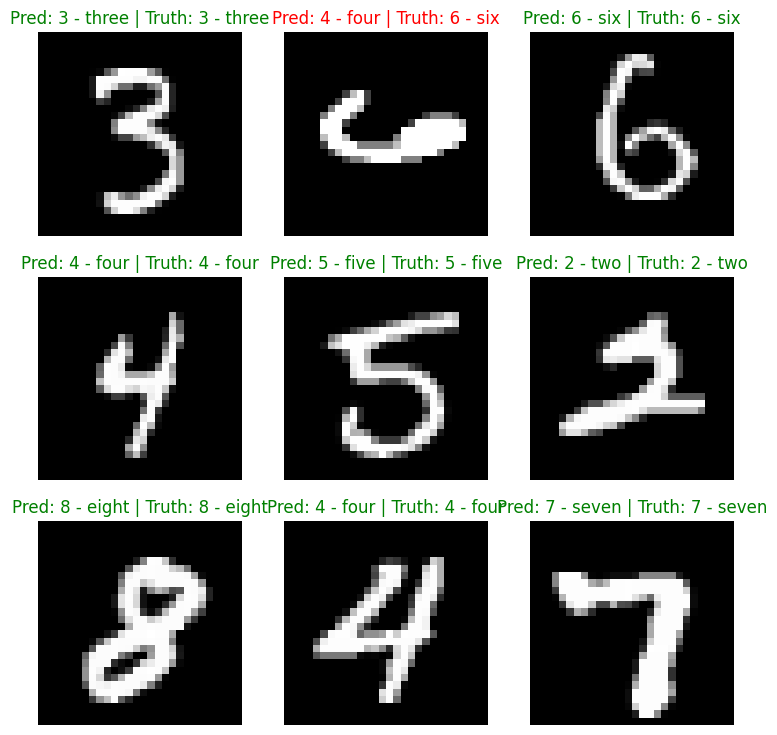

In [71]:
plt.figure(figsize=(9, 9))
nrows, ncols = 3, 3

for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)

    plt.imshow(sample.squeeze(), cmap='gray')

    pred_label = pred_labels[i]

    truth_label = test_data.classes[test_labels[i]]

    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    if pred_label == truth_label:
        plt.title(title_text, c='g')
    else:
        plt.title(title_text, c='r')

    plt.axis(False)

## 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

In [72]:
%pip install mlxtend
%pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [73]:
y_preds = []
y_trues = []

model_1.eval()

with torch.inference_mode():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)

        y_logit = model_1(X)

        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)

        y_preds.append(y_pred.cpu())
        y_trues.append(y.cpu())

y_pred_tensor = torch.cat(y_preds)
y_true_tensor = torch.cat(y_trues)

In [74]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Set up confusion instance and compare predictions to targets
confmat = ConfusionMatrix(task='multiclass', num_classes=len(test_data.classes))
confmat_tensor = confmat(preds=y_pred_tensor, target=y_true_tensor)
confmat_tensor

tensor([[ 972,    0,    2,    0,    0,    0,    5,    1,    0,    0],
        [   1, 1118,    4,    2,    0,    0,    4,    3,    3,    0],
        [   0,    0, 1025,    0,    1,    0,    0,    3,    3,    0],
        [   0,    0,    2, 1004,    0,    3,    0,    1,    0,    0],
        [   0,    0,    0,    0,  974,    0,    1,    0,    1,    6],
        [   0,    0,    0,    5,    0,  884,    1,    0,    0,    2],
        [   2,    1,    1,    0,    3,    5,  946,    0,    0,    0],
        [   0,    0,    9,    2,    0,    0,    0, 1011,    2,    4],
        [   1,    0,    4,    2,    0,    1,    3,    0,  962,    1],
        [   0,    0,    0,    3,    3,    3,    0,    4,    5,  991]])

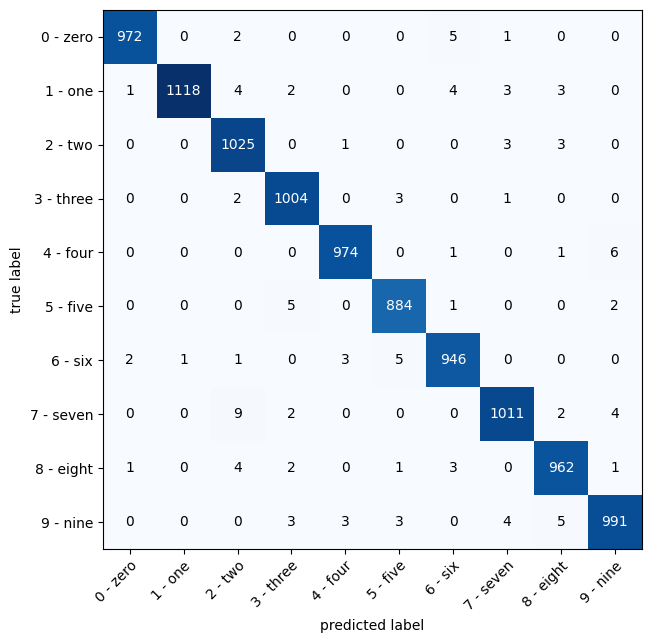

In [75]:
fix, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=test_data.classes,
    figsize=(10, 7)
)

## 12. Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?

In [78]:
tensor = torch.randn(size=(1, 3, 64, 64))

layer_1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=2)
layer_2 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=4)

mod_tensor_1 = layer_1(tensor)
mod_tensor_2 = layer_2(tensor)

mod_tensor_1.shape, mod_tensor_2.shape

(torch.Size([1, 5, 63, 63]), torch.Size([1, 5, 61, 61]))

## 13. Use a model similar to the trained `model_2` from notebook 03 to make predictions on the test [`torchvision.datasets.FashionMNIST`](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) dataset. 
* Then plot some predictions where the model was wrong alongside what the label of the image should've been. 
* After visualing these predictions do you think it's more of a modelling error or a data error? 
* As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?